<a href="https://colab.research.google.com/github/CarlosVargasF/Stage_Liris_Vargas/blob/master/Code/func_test_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install infomap
!pip install wurlitzer
!pip install leidenalg 
!pip install git+https://github.com/GiulioRossetti/cdlib.git > /dev/null
!pip install angel-cd
!pip install tqdm

#Install graph-tool
#!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
#!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
#!apt-get update
#!apt-get install python3-graph-tool python3-cairo python3-matplotlib

     |████████████████████████████████| 266kB 8.6MB/s 
  Created wheel for infomap: filename=infomap-1.1.3-cp36-cp36m-linux_x86_64.whl size=5660402 sha256=df935d3e1bd75ce3371bbcfdd97d7d157ebcfccecbef6600eeaad95be20cbb71
  Stored in directory: /root/.cache/pip/wheels/63/31/ca/9ed0af4c2da472ea989c966c26a6ff448b76f39cb5db82960e
Successfully built infomap
     |████████████████████████████████| 2.4MB 7.9MB/s 
     |████████████████████████████████| 3.2MB 52.3MB/s 
  Running command git clone -q https://github.com/GiulioRossetti/cdlib.git /tmp/pip-req-build-jxdmfx48


In [2]:
#libraries
from cdlib import algorithms
from cdlib import NodeClustering
from cdlib import evaluation
import networkx as nx
import time
import pandas as pd
import numpy as np
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

#visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#testing
import signal
from contextlib import contextmanager
import traceback
from tqdm import notebook
import progressbar 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Generic Function (Internal)

In [3]:
#*********************** INNER FUNC (GENERIC FUNCTION)*************************************
def evaluate(graph_comms_list, algorithm_dict, eval_method_dict, benchmark, case_name=None, show_eval_progress=False):
  
  #Define time limit for one single graph treatement
  class TimeoutException(Exception): pass

  @contextmanager
  def time_limit(seconds):
    def signal_handler(signum, frame):
      raise TimeoutException("Timed out! The algorithm has taken more than {} seconds over one single graph".format(seconds))
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
      yield
    finally:
      signal.alarm(0)

  #Manage case_name param
  if case_name:
    case = case_name
  else:
    case = '-'  
  
  #Check graph_comms_list parameter
  if isinstance(graph_comms_list, list) and len(graph_comms_list):
    graphs = [gc[0] for gc in graph_comms_list] 
    communities = [gc[1] for gc in graph_comms_list]
    attributs = [gc[2] for gc in graph_comms_list]
  elif isinstance(graph_list, tuple):
    graphs = list(graph_comms_list[0])
    communities = list(graph_comms_list[1])
    attributs = list([gc[2] for gc in graph_comms_list]) 
  else:
    raise ValueError("Please insert a list of tuples or a list of lists (graph, commnunities, attrib).")

  #Creation of NodeClustering objects     
  lfr_nodclust_obj = [NodeClustering(C, G, 'Ground Truth') for C, G in zip(communities, graphs)]

  #Application of algorithms over all the benchmarks
  res = pd.DataFrame(columns=['Algorithm', 'Graph', 'Score', 'Metric', 'Benchmark', 'Case', 'Exec_Time', 'Status', 'N', 'Size_C', 'ut', 'Rep'])

  #error_log = ""   
  for alg in algorithm_dict:
    algo_data = []     
    #Check alg
    if isinstance(algorithm_dict[alg], list) or isinstance(algorithm_dict[alg], tuple):
      for G, C, A, func in zip(graphs, lfr_nodclust_obj, attributs, algorithm_dict[alg]):        
        #try:
          with time_limit(60):
            s_time = time.time()
            solution = func(G)
            e_time = time.time() - s_time
          for method in eval_method_dict:
            #Performance evaluation 
            perf = eval_method_dict[method](C, solution)
            algo_data.append([alg, A['name'], perf[0], method, benchmark, case, e_time, 'ok', float(A['n'])*1000, A['sz'], float(A['ut']), float(A['rep'])])          
        
    elif isinstance(algorithm_dict[alg], dict):
      for G, C, A, func in zip(graphs, lfr_nodclust_obj, attributs, algorithm_dict[alg]):        
        #try:
          with time_limit(60):
            s_time = time.time()
            solution = algorithm_dict[alg][func](G)
            e_time = time.time() - s_time
          for method in eval_method_dict:
            #Performance evaluation 
            perf = eval_method_dict[method](C, solution)
            algo_data.append([alg, A['name'], perf[0], method, benchmark, case, e_time, 'ok', float(A['n'])*1000, A['sz'], float(A['ut']), float(A['rep'])])
        
    else: 
      for G, C, A, progression in zip(graphs, lfr_nodclust_obj, attributs, notebook.trange(len(graph_comms_list), initial=1, desc="Graphs treated: ")):        
        #try:
          with time_limit(60):
            s_time = time.time()
            solution =  algorithm_dict[alg](G)
            e_time = time.time() - s_time
          if show_eval_progress == False:
            for method in eval_method_dict:
              #Performance evaluation 
              perf = eval_method_dict[method](C, solution)
              algo_data.append([alg, A['name'], perf[0], method, benchmark, case, e_time, 'ok', float(A['n'])*1000, A['sz'], float(A['ut']), float(A['rep'])])
          else:
            for method, progression2 in zip(eval_method_dict, notebook.trange(len(eval_method_dict), initial=1, desc="Evaluating performance...")):
              #Performance evaluation 
              perf = eval_method_dict[method](C, solution)
              algo_data.append([alg, A['name'], perf[0], method, benchmark, case, e_time, 'ok', float(A['n'])*1000, A['sz'], float(A['ut']), float(A['rep'])]) 
            
    #Update of results
    algo_data_df = pd.DataFrame(algo_data, columns=['Algorithm', 'Graph', 'Score', 'Metric', 'Benchmark', 'Case', 'Exec_Time', 'Status', 'N', 'Size_C', 'ut', 'Rep'])
    #algo_data_df['NMI'] = perf_df['score']
    res = pd.concat([res, algo_data_df], ignore_index=True)  

  return res

#Estandardization Function (External)

In [13]:
# *********************************** OUTTER FUNC (STANDARD TEST CASES) *******************************************

def evaluate_and_compare(algos_list, methods_list, benchmark_type, case_list='all'):
  '''
  Some CD algorthms (CDlib) <algos_list>       [CD algorithms to apply] :
    - 'gn'            [girvan_newman]
    - 'greedy'        [greedy_modularity (Clauset et al)]
    - 'louvain'       [louvain (Blondel et al)]
    - 'cfinder'       [kclique]
    - 'mcl'           [markov_clustering]
    - 'infomap'       [infomap]
    - 'em'            [expectation-maximization]
    - 'leiden'        [leiden]
  
  Partition evaluation methods (CDlib) <methods_list>       [evaluation metric to apply] :
    - 'nmi'           [Normalized Mutual Information]
    - 'ami'           [Adjusted Mutual Information]
    - 'ari'           [Adjusted rand index]
    - 'f1'            [F1 score]
    - 'nf1'           [Normalized F1 score]
    - 'omega'         [Index of resemblance for overlapping]
    - 'onmi_lfk'      [Overlapping Normalized Mutual Information 1]
    - 'onmi_mgh'      [Overlapping Normalized Mutual Information 2]
    - 'var_inf'       [Variation of Information]

  Possible values for <benchmark_type>       [benchmark to evaluate] :
    - 'lfr_undir_unwei'
    - 'lfr_undir_wei'
    - 'lfr_dir_unwei'
    - 'lfr_undir_unwei_ovlp'

  Possible values for <case_list> : See cases for each benchmark below.      
    * It is possible to select multiple cases passing them as a list or a 
      comma-separated string.
    * Default value: 'all'. Take all possible cases for selected benchmark. 

  '''

  #Possible cases for undirected and unweighted benchmarks
  src_undir_unwei = [
    'n_1k_sz_small', 
    'n_1k_sz_big',   
    'n_5k_sz_small', 
    'n_5k_sz_big'   
  ]

  #Possible cases for undirected and weighted benchmarks
  src_undir_wei = [
    'n_5k_sz_small_ut_05',
    'n_5k_sz_small_ut_08',    
    'n_5k_sz_big_ut_05',  
    'n_5k_sz_big_ut_08'   
  ]

  #Possible cases for directed and unweighted benchmarks
  src_dir_unwei = [
    'n_1k_sz_small', 
    'n_1k_sz_big',   
    'n_5k_sz_small', 
    'n_5k_sz_big'   
  ]

  #Possible cases for undirected and unweighted with overlapping benchmarks
  src_undir_unwei_ovlp = [
    'n_5k_sz_small_ut_01', 
    'n_5k_sz_small_ut_03', 
    'n_5k_sz_big_ut_01',  
    'n_5k_sz_big_ut_03'   
  ] 
    
  start_time = time.time()
  
  #CD Algorithms names list (Crisp Communities)
  algos_dict = {
    # Crisp communities      
    'girvan_newman'                  : algorithms.girvan_newman,       
    'greedy_modularity'              : algorithms.greedy_modularity,
    'louvain'                        : algorithms.louvain,
    'kclique'                        : algorithms.kclique,
    'markov_clustering'              : algorithms.markov_clustering,
    'infomap'                        : algorithms.infomap,
    'em'                             : algorithms.em,
    'leiden'                         : algorithms.leiden,
    
    'agdl'                           : algorithms.agdl,
    'aslpaw'                         : algorithms.aslpaw,
    'async_fluid'                    : algorithms.async_fluid,
    'cpm'                            : algorithms.cpm,
    'der'                            : algorithms.der,
    'edmot'                          : algorithms.edmot,
    'eigenvector'                    : algorithms.eigenvector,
    'gdmp2'                          : algorithms.gdmp2,
    'label_propagation'              : algorithms.label_propagation,
    'rber_pots'                      : algorithms.rber_pots,
    'rb_pots'                        : algorithms.rb_pots,
    'scan'                           : algorithms.scan,
    'significance_communities'       : algorithms.significance_communities,
    'spinglass'                      : algorithms.spinglass,
    'surprise_communities'           : algorithms.surprise_communities,
    'walktrap'                       : algorithms.walktrap,
    'sbm_dl'                         : algorithms.sbm_dl,
    'sbm_dl_nested'                  : algorithms.sbm_dl_nested,

    # Overlapping communities
    'angel'                          : algorithms.angel,
    'big_clam'                       : algorithms.big_clam,
    'conga'                          : algorithms.conga,
    'congo'                          : algorithms.congo,
    'danmf'                          : algorithms.danmf,
    'demon'                          : algorithms.demon,
    'ego_networks'                   : algorithms.ego_networks,
    'egonet_splitter'                : algorithms.egonet_splitter,
    'kclique'                        : algorithms.kclique,
    'lais2'                          : algorithms.lais2,
    'lemon'                          : algorithms.lemon,
    'lfm'                            : algorithms.lfm,
    'multicom'                       : algorithms.multicom,
    'nmnf'                           : algorithms.nmnf,
    'nnsed'                          : algorithms.nnsed,
    'node_perception'                : algorithms.node_perception,
    'overlapping_seed_set_expansion' : algorithms.overlapping_seed_set_expansion,
    'percomvc'                       : algorithms.percomvc,
    'slpa'                           : algorithms.slpa,
  }

  #Partition comparison metrics (CDlib)
  methods_dict = {
    'nmi'      : evaluation.normalized_mutual_information,
    'ami'      : evaluation.adjusted_mutual_information,
    'ari'      : evaluation.adjusted_rand_index,
    'f1'       : evaluation.f1,
    'nf1'      : evaluation.nf1,
    'omega'    : evaluation.omega,
    'onmi_lfk' : evaluation.overlapping_normalized_mutual_information_LFK,
    'onmi_mgh' : evaluation.overlapping_normalized_mutual_information_MGH,
    'vi'       : evaluation.variation_of_information
  }

  #Importing and reading benchmark files

  #Url base path
  url = 'https://github.com/CarlosVargasF/LFR_benchmarks_for_testing/raw/56cef2be81625f642684ca20e12b5563f615c25a/'
  
   
  #Graph type
  #parameters for graph generation
  data_edg=False
  create_using=nx.Graph
  #Select file folders and adjust some parameters
  if isinstance(benchmark_type, str) and len(benchmark_type):
    if benchmark_type == 'undir_unwei':
      url = url + 'undirected_unweighted/lfr_'
      src = src_undir_unwei            
    elif benchmark_type == 'undir_wei':
      url = url + 'undirected_weighted/lfr_'
      data_edg=(('weight',float),)
      src = src_undir_wei
    elif benchmark_type == 'dir_unwei':
      url = url + 'directed_unweighted/lfr_'
      create_using=nx.DiGraph
      src = src_dir_unwei
    elif benchmark_type == 'undir_unwei_ovlp':
      url = url + 'undirected_unweighted_overlap/lfr_'
      src = src_undir_unwei_ovlp
    #--------------Small testing overlap benchmark------------------  
    elif benchmark_type == 'test':
      url = url + 'testing_overlap/lfr_'
      src = ['n_5k_sz_small_ut_03']
    #---------------------------------------------------------------  
    else:
      raise ValueError('benchmark_type not supported')
  else:
    raise TypeError('Insert a valide benchmark_type as a string')

  #Checking case parameter  
  if isinstance(case_list, str): 
    if case_list == 'all':
      cases = src
    else:
      cases = list(case_list.split())
  elif (isinstance(case_list, list)) and (len(case_list)): 
    if any(not(c in src) for c in case_list):
      raise ValueError('Invalid <case> option. Verify available cases for the selected benchmark.')
    cases = case_list    
  else:
    raise TypeError('Invalid <case> input format. Please insert a list or a space-separated string of valide options or "all" for use all of them.')
  
  #Checking algos_list parameter
  if (isinstance(algos_list, str)):
    for a in list(algos_list.split()):
      if not(a in algos_dict):
        raise ValueError('Invalid algos_dict key. Verify available algorithm names.')
    algos = dict((k, v) for k, v in algos_dict.items() if k in list(algos_list.split()))
    
  elif (isinstance(algos_list, list)) and (len(algos_list)): 
    for a in algos_list:
      if not(a in algos_dict):
        raise ValueError('Invalid algos_dict key. Verify available algorithm names.')
    algos = dict((k, v) for k, v in algos_dict.items() if k in algos_list)    
  else:
    raise TypeError('Invalid <algos_list> input format. Please insert a list or a space-separated string of valide algorithm names.') 

  #Checking methods_list parameter
  if (isinstance(methods_list, str)):
    methods = dict((k, v) for k, v in methods_dict.items() if k in list(methods_list.split()))
  elif (isinstance(methods_list, list)) and (len(methods_list)): 
    for m in methods_list:
      if not(m in methods_dict):
        raise ValueError('Invalid methods_dict key. Verify available evaluation method names.')
    methods = dict((k, v) for k, v in methods_dict.items() if k in methods_list)    
  else:
    raise TypeError('Invalid <methods_list> input format. Please insert a list or a space-separated string of evaluation method names.') 

  #Creation of specific functions for some algoritmhs with aditional parameters
  #!!! For each function check parameter values (current only for testing) !!!

  special_algos = ['gn','em','async_fluid','agdl','scan','kclique','angel',
                     'conga','congo','demon','lemon','lfm','multicom','node_perception', 'overlapping_seed_set_expansion']
  if any((a in algos for a in special_algos)):
    if 'gn' in algos:
      def gn(n_coms) : return lambda G : algorithms.girvan_newman(G, n_coms)
      algos['gn'] = [gn(len(c)) for c in lfr_comms] 

    if 'em' in algos:
      def em(n_coms) : return lambda G : algorithms.em(G, n_coms)
      algos['em'] = [em(len(c)) for c in lfr_comms]

    if 'async_fluid' in algos:
      def async(n_coms) : return lambda G : algorithms.async_fluid(G, n_coms)
      algos['async_fluid'] = [async(len(c)) for c in lfr_comms]

    if 'agdl' in algos:
      def agdl(n_coms, nn, kc, a) : return lambda G : algorithms.agdl(G, n_coms, nn, kc, a)
      algos['agdl'] = [agdl(len(c), 3, 4, 1) for c in lfr_comms]  

    if 'scan' in algos:
      def scan(ep, mu) : return lambda G : algorithms.scan(G, ep, mu)
      algos['scan'] = scan(0.7, 3)  

    if 'kclique' in algos:
      def kclique(k) : return lambda G : algorithms.kclique(G, k)
      algos['kclique'] = kclique(20)
    
    if 'angel' in algos:
      def angel(threshold , min_com_size) : return lambda G : algorithms.angel(G, threshold, min_com_size)
      algos['angel'] = angel(0.25, 20)  

    if 'conga' in algos:
      def conga(n_coms) : return lambda G : algorithms.conga(G, n_coms)
      algos['conga'] = [conga(len(c)) for c in lfr_comms]
    
    if 'congo' in algos:
      def congo(n_coms) : return lambda G : algorithms.congo(G, n_coms)
      algos['congo'] = [congo(len(c)) for c in lfr_comms]

    if 'demon' in algos:
      def demon(min_com_size) : return lambda G : algorithms.demon(G, min_com_size)
      algos['demon'] = demon(20)  
    
    if 'lemon' in algos:
      def lemon(seeds, min_com_size, max_com_size) : return lambda G : algorithms.lemon(G, seeds=seeds, min_com_size=min_com_size, max_com_size=max_com_size)
      seeds = [1, 2, 3]
      algos['lemon'] = lemon(seeds, 20, 100)  

    if 'lfm' in algos:
      def lfm(alpha) : return lambda G : algorithms.lfm(G, alpha) 
      algos['lfm'] = lfm(1)

    if 'multicom' in algos:
      def multicom(seed_node) : return lambda G : algorithms.multicom(G, seed_node)
      algos['multicom'] = multicom(1)

    if 'node_perception' in algos:
      def node_perception(threshold , overlap_threshold ) : return lambda G : algorithms.node_perception(G, threshold, overlap_threshold)
      algos['node_perception'] = node_perception(0.25, 0.25)
    
    if 'overlapping_seed_set_expansion' in algos:
      def osse(seeds) : return lambda G : algorithms.overlapping_seed_set_expansion(G, seeds=seeds)
      seeds = [1, 2, 3]
      algos['overlapping_seed_set_expansion'] = osse(seeds)  

  #Generate graphs according to cases   
  results = pd.DataFrame(columns=['Algorithm', 'Graph', 'Score', 'Metric', 'Benchmark', 'Case', 'Exec_Time', 'Status', 'N', 'Size_C', 'ut', 'Rep'])
  for case in cases:   
    base_path = url + case 

    #Open zip files
    zip_comms = urlopen(base_path + '/cnl_files.zip')
    zip_edges = urlopen(base_path + '/nse_files.zip')
    zipfile_c = ZipFile(BytesIO(zip_comms.read()))
    zipfile_e = ZipFile(BytesIO(zip_edges.read()))

    #Read data files
    data_comms = [zipfile_c.open(line1).read().decode('utf-8').splitlines() for line1 in zipfile_c.namelist()]
    data_edges = [(zipfile_e.open(line2), line2) for line2 in zipfile_e.namelist()]
        
    #Construction of the lfr graphs

    #List of graphs
    lfr_graphs = []
    #List of graph_attribute dictionaries 
    graph_attributes = []

    for edge_file in data_edges:
      attrib_dict = {}
      g = nx.read_edgelist(edge_file[0], nodetype=int, data=data_edg, create_using=create_using)
      #g.name = edge_file[1]

      # case --> (name, n, size_comms) / edge_file --> (ut, rep, [uw, ovlp_fraction])
      attribs_1 = case.split('_')
      attribs_2 = edge_file[1].split('_')
      
      attrib_dict.update([('name', edge_file[1][:-4]),('n', attribs_1[attribs_1.index('n')+1][:-1]), ('sz', attribs_1[attribs_1.index('sz')+1]),
                          ('ut', attribs_2[attribs_2.index('ut')+1]), ('rep', attribs_2[attribs_2.index('rep')+1][:-4])])
      lfr_graphs.append(g)
      graph_attributes.append(attrib_dict)

    #Construction of the lfr communities
    lfr_comms = [[list(map(int, item.split())) for item in comm_file] for comm_file in data_comms]
    
    #Formating for <evaluate> function 
    graphs_comms_atts = [(g, c, a) for g, c, a in zip(lfr_graphs, lfr_comms, graph_attributes)]
   
    #----------INNER FUNC CALL--------------------------------------------------

    #Apply selected CD algorithms and evaluate them according to selected methods
    res_eval = evaluate(graphs_comms_atts, algos, methods, benchmark_type, case)

    #----------INNER FUNC CALL--------------------------------------------------

    results = pd.concat([results, res_eval], ignore_index=True)

  total_time = (time.time() - start_time)
  print("")  
  print("--- Total function execution time: %d min %d sec ---" % (total_time // 60, total_time % 60))  
  print("")
  print("                              *** Execution Succeded! ***")

  return results 


# **Agorithm Test Report**

# 1. Crisp communities

## 1.1 Algorithms presented in [paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.80.056117)

In [ ]:
# Girvan and Newman --------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('girvan_newman', 'nmi', 'undir_unwei', 'n_1k_sz_small')

TimeoutException: ignored

In [15]:
# Greedy ------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('greedy_modularity', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 3 min 55 sec ---

                              *** Execution Succeded! ***


In [16]:
# Louvain ------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('louvain', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 0 min 45 sec ---

                              *** Execution Succeded! ***


In [ ]:
# kclique ------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('kclique', 'nmi', 'undir_unwei', 'n_1k_sz_small')

ValueError: ignored

In [17]:
# Markov Clustering -------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('markov_clustering', 'nmi', 'undir_unwei', 'n_1k_sz_small')

ValueError: ignored

In [18]:
# Infomap ------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('infomap', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 0 min 19 sec ---

                              *** Execution Succeded! ***


In [ ]:
# Expectation - Maximization ------------------------------------------------------ TEST RESULT : ERR
p=evaluate_and_compare('em', 'nmi', 'undir_unwei', 'n_1k_sz_small')

NetworkXError: ignored

In [19]:
# Leiden ------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('leiden', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 0 min 17 sec ---

                              *** Execution Succeded! ***


## - Other algorithms in CDlib

In [ ]:
# Agdl --------------------------------------------------------------------------- TEST RESULT : ERR 
p=evaluate_and_compare('agdl', 'nmi', 'undir_unwei', 'n_1k_sz_small')

ValueError: ignored

In [20]:
# ASLPAw ------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('aslpaw', 'nmi', 'undir_unwei', 'n_1k_sz_small')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You shoul

TimeoutException: ignored

In [ ]:
# Async fluid ------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('async_fluid', 'nmi', 'undir_unwei', 'n_1k_sz_small')

NetworkXError: ignored

In [21]:
# Cpm ------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('cpm', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 0 min 19 sec ---

                              *** Execution Succeded! ***


In [22]:
# Der ------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('der', 'nmi', 'undir_unwei', 'n_1k_sz_small')

/usr/local/lib/python3.6/dist-packages/cdlib/algorithms/internal/DER.py:140: RuntimeWarning: divide by zero encountered in log
  log_param = np.log(param)
/usr/local/lib/python3.6/dist-packages/cdlib/algorithms/internal/DER.py:140: RuntimeWarning: divide by zero encountered in log
  log_param = np.log(param)
/usr/local/lib/python3.6/dist-packages/cdlib/algorithms/internal/DER.py:140: RuntimeWarning: divide by zero encountered in log
  log_param = np.log(param)
/usr/local/lib/python3.6/dist-packages/cdlib/algorithms/internal/DER.py:140: RuntimeWarning: divide by zero encountered in log
  log_param = np.log(param)
/usr/local/lib/python3.6/dist-packages/cdlib/algorithms/internal/DER.py:140: RuntimeWarning: divide by zero encountered in log
  log_param = np.log(param)
/usr/local/lib/python3.6/dist-packages/cdlib/algorithms/internal/DER.py:140: RuntimeWarning: divide by zero encountered in log
  log_param = np.log(param)
/usr/local/lib/python3.6/dist-packages/cdlib/algorithms/internal/DER.p


--- Total function execution time: 0 min 44 sec ---

                              *** Execution Succeded! ***


In [ ]:
# Edmot ------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('edmot', 'nmi', 'undir_unwei', 'n_1k_sz_small')

AssertionError: ignored

In [ ]:
# Eigenvector -------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('eigenvector', 'nmi', 'undir_unwei', 'n_1k_sz_small')

/usr/local/lib/python3.6/dist-packages/igraph/__init__.py:1153: RuntimeWarning: ARPACK solver failed to converge (3001 iterations, 0/1 eigenvectors converged) at /project/vendor/source/igraph/src/arpack.c:819
  membership, _, q = GraphBase.community_leading_eigenvector(self, clusters, **kwds)


InternalError: ignored

In [ ]:
# Gdmp2 ------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('gdmp2', 'nmi', 'undir_unwei', 'n_1k_sz_small')

ValueError: ignored

In [23]:
# Label_propagation ----------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('label_propagation', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 0 min 14 sec ---

                              *** Execution Succeded! ***


In [24]:
# Rber_pots ------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('rber_pots', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 0 min 16 sec ---

                              *** Execution Succeded! ***


In [25]:
# Rb_pots ---------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('rb_pots', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 0 min 16 sec ---

                              *** Execution Succeded! ***


In [ ]:
# Scan (Structural clustering algo) ------------------------------------------------ TEST RESULT : ERR 
p=evaluate_and_compare('scan', 'nmi', 'undir_unwei', 'n_1k_sz_small')

ValueError: ignored

In [27]:
# Significance communities ----------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('significance_communities', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 0 min 21 sec ---

                              *** Execution Succeded! ***


In [ ]:
# Spinglass ------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('spinglass', 'nmi', 'undir_unwei', 'n_1k_sz_small')

InternalError: ignored

In [28]:
# Surprise_communities ------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('surprise_communities', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 0 min 17 sec ---

                              *** Execution Succeded! ***


In [29]:
# Walktrap ------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('walktrap', 'nmi', 'undir_unwei', 'n_1k_sz_small')


--- Total function execution time: 0 min 26 sec ---

                              *** Execution Succeded! ***


In [ ]:
# Sbm_dl (stockastic block model)---------------------------------------------------- TEST RESULT : OK 
p=evaluate_and_compare('sbm_dl', 'nmi', 'undir_unwei', 'n_1k_sz_small')

--- Total execution time: 6 min 37 sec ---


In [ ]:
# Sbm dl nested (stockastic block model)----------------------------------------- TEST RESULT : OK 
p=evaluate_and_compare('sbm_dl_nested', 'nmi', 'undir_unwei', 'n_1k_sz_small')

--- Total function execution time: 21 min 6 sec ---

**************************** Execution Succeded! **************************************


# 2. Overlapping communities
### 2.1 Algorithms presented in [paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.80.056117)

In [ ]:
# Angel --------------------------------------------------------------------------TEST RESULT : ERR 
p=evaluate_and_compare('angel', 'onmi_lfk', 'undir_unwei_ovlp', 'n_5k_sz_small_ut_01')

ValueError: ignored

In [ ]:
# big_clam ------------------------------------------------------------------------TEST RESULT : ERR
p=evaluate_and_compare('big_clam', 'onmi_lfk', 'undir_unwei_ovlp', 'n_5k_sz_small_ut_01')

AssertionError: ignored

In [ ]:
# conga -------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('conga', 'onmi_lfk', 'test')

 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 

TimeoutException: ignored

In [ ]:
# congo -------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('congo', 'onmi_lfk', 'undir_unwei_ovlp', 'n_5k_sz_small_ut_01')

TimeoutException: ignored

In [30]:
# danmf -------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('danmf', 'onmi_lfk', 'test')


--- Total function execution time: 4 min 18 sec ---

                              *** Execution Succeded! ***


In [5]:
# demon -------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('demon', 'onmi_mgh', 'test')

TimeoutException: ignored

In [76]:
# ego_networks -------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('ego_networks', 'onmi_lfk', 'test')


--- Total function execution time: 86 min 26 sec ---

                              *** Execution Succeded! ***


In [ ]:
# egonet_splitter -------------------------------------------------------------------------- TEST RESULT : -
p=evaluate_and_compare('egonet_splitter', 'onmi_lfk', 'test')

In [77]:
# kclique -------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('kclique', 'onmi_lfk', 'test')


--- Total function execution time: 0 min 8 sec ---

                              *** Execution Succeded! ***


In [ ]:
# lais2 -------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('lais2', 'onmi_lfk', 'undir_unwei_ovlp', 'n_5k_sz_small_ut_01')

TimeoutException: ignored

In [10]:
# lemon --------------------------------------------------------------------------TEST RESULT : OK 
p=evaluate_and_compare('lemon', 'onmi_lfk', 'test')

/usr/local/lib/python3.6/dist-packages/pulp/pulp.py:1190: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")



--- Total function execution time: 1 min 28 sec ---

                              *** Execution Succeded! ***


In [ ]:
# lfm -------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('lfm', 'onmi_lfk', 'undir_unwei_ovlp', 'n_5k_sz_small_ut_01')

TimeoutException: ignored

In [74]:
# multicom -------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('multicom', 'onmi_lfk', 'test')


--- Total function execution time: 2 min 9 sec ---

                              *** Execution Succeded! ***


In [ ]:
# nmnf ---------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('nmnf', 'onmi_lfk', 'undir_unwei_ovlp', 'n_5k_sz_small_ut_01')

AssertionError: ignored

In [ ]:
# nnsed -------------------------------------------------------------------------- TEST RESULT : ERR
p=evaluate_and_compare('nnsed', 'onmi_lfk', 'undir_unwei_ovlp', 'n_5k_sz_small_ut_01')

AssertionError: ignored

In [ ]:
# node_perception -------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('node_perception', 'onmi_lfk', 'test')


--- Total function execution time: 115 min 30 sec ---

                              *** Execution Succeded! ***


In [14]:
# overlapping_seed_set_expansion ------------------------------------------------------------TEST RESULT : OK 
p=evaluate_and_compare('overlapping_seed_set_expansion', 'onmi_lfk', 'test')


--- Total function execution time: 0 min 7 sec ---

                              *** Execution Succeded! ***


In [ ]:
# percomvc -------------------------------------------------------------------------- TEST RESULT : OK
p=evaluate_and_compare('percomvc', 'onmi_lfk', 'test')


--- Total function execution time: 8 min 29 sec ---

                              *** Execution Succeded! ***


In [ ]:
# slpa -------------------------------------------------------------------------- TEST RESULT : OK 
p=evaluate_and_compare('slpa', 'onmi_lfk', 'test')


--- Total function execution time: 14 min 42 sec ---

                              *** Execution Succeded! ***


#**Visualization**

##Plotting Function (plt - sns) 

In [31]:
def plot_and_compare(dataframe, algos_to_compare='all', cases_to_compare='all', heat_map=False):
  #set style
  plt.style.use('default')
  algos_in_df = dataframe['Algorithm'].unique()
  cases_in_df = dataframe['Case'].unique()
  
  if algos_to_compare=='all' and cases_to_compare=='all':
    if heat_map == False:
      ax = plt.gca()      
      dataframe.groupby(['ut','Algorithm', 'Case']).mean().unstack().unstack().plot(y = 'Score', ax = ax)
      ax.set_xlabel('Mixing parameter (ut)')
      ax.set_ylabel('Score')
      plt.title('CD Algorithm comparison')
      plt.grid()
      plt.show()      
    else:
      new_df = pd.DataFrame(index=algos_in_df, columns=cases_in_df)
      for alg in algos_in_df:
        for ca in cases_in_df:
          data = dataframe[(dataframe['Algorithm'] == alg) & (dataframe['Case'] == ca)]
          new_df.loc[new_df.index == alg, ca] = float(data.groupby(['ut']).mean()['Score'].mean())
      new_df = new_df.astype(float)      
      sns.heatmap(new_df, annot=True)    
  else:
    #Check input values (algos_to_compare)    
    if isinstance(algos_to_compare, str): 
      if algos_to_compare == 'all':
        algos_to_compare = algos_in_df
      else:
        algos_to_compare = list(algos_to_compare.split())
    elif (isinstance(algos_to_compare, list)) and (len(algos_to_compare)): 
      if any(not(c in algos_in_df) for c in algos_to_compare):
        raise ValueError('Invalid <algorithm> option. Verify available algorithm for current dataframe.')
      algos_to_compare = algos_to_compare    
    else:
      raise TypeError('Invalid <algorithm> input format. Please insert a list or a space-separated string of valide options or "all" to compare all of them.')

    #Check input values (cases_to_compare)    
    if isinstance(cases_to_compare, str): 
      if cases_to_compare == 'all':
        cases_to_compare = cases_in_df
      else:
        cases_to_compare = list(cases_to_compare.split())
    elif (isinstance(cases_to_compare, list)) and (len(cases_to_compare)): 
      if any(not(c in cases_in_df) for c in cases_to_compare):
        raise ValueError('Invalid <case> option. Verify available case for current dataframe.')
      cases_to_compare = cases_to_compare    
    else:
      raise TypeError('Invalid <case> input format. Please insert a list or a space-separated string of valide options or "all" to compare all of them.')

    #Plot user-defined options
    if heat_map == False:
      ax = plt.gca()
      ax.set_ylabel('Score')
      for alg in algos_to_compare:
        for ca in cases_to_compare:
          data = dataframe[(dataframe['Algorithm'] == alg) & (dataframe['Case'] == ca)]
          data.groupby(['ut', 'Algorithm', 'Case']).mean().unstack().unstack().plot(y = 'Score', ax = ax)
      plt.grid()    
      plt.title('Custom Comparison')
      plt.show()
    else:
      new_df = pd.DataFrame(index=algos_to_compare, columns=cases_to_compare)
      for alg in algos_to_compare:
        for ca in cases_to_compare:
          data = dataframe[(dataframe['Algorithm'] == alg) & (dataframe['Case'] == ca)]
          new_df.loc[new_df.index == alg, ca] = data.groupby(['ut']).mean()['Score'].mean()
      new_df = new_df.astype(float)
      sns.heatmap(new_df, annot=True)

In [32]:
# Testing dataframe 
df=evaluate_and_compare('infomap leiden', 'nmi', 'undir_unwei', 'n_1k_sz_small n_1k_sz_big')


--- Total function execution time: 1 min 5 sec ---

                              *** Execution Succeded! ***


In [33]:
df

,Algorithm,Graph,Score,Metric,Benchmark,Case,Exec_Time,Status,N,Size_C,ut,Rep
0,infomap,lfr_ut_0.0_rep_0,0.965576,nmi,undir_unwei,n_1k_sz_small,0.107792,ok,1000.0,small,0.0,0.0
1,infomap,lfr_ut_0.0_rep_1,0.977391,nmi,undir_unwei,n_1k_sz_small,0.096579,ok,1000.0,small,0.0,1.0
2,infomap,lfr_ut_0.0_rep_2,0.962274,nmi,undir_unwei,n_1k_sz_small,0.100659,ok,1000.0,small,0.0,2.0
3,infomap,lfr_ut_0.0_rep_3,0.945468,nmi,undir_unwei,n_1k_sz_small,0.101076,ok,1000.0,small,0.0,3.0
4,infomap,lfr_ut_0.0_rep_4,0.961713,nmi,undir_unwei,n_1k_sz_small,0.096241,ok,1000.0,small,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
435,leiden,lfr_ut_1.0_rep_5,0.029550,nmi,undir_unwei,n_1k_sz_big,0.085753,ok,1000.0,big,1.0,5.0
436,leiden,lfr_ut_1.0_rep_6,0.018649,nmi,undir_unwei,n_1k_sz_big,0.084917,ok,1000.0,big,1.0,6.0
437,leiden,lfr_ut_1.0_rep_7,0.026190,nmi,undir_unwei,n_1k_sz_big,0.078627,ok,1000.0,big,1.0,7.0
438,leiden,lfr_ut_1.0_rep_8,0.032085,nmi,undir_unwei,n_1k_sz_big,0.082353,ok,1000.0,big,1.0,8.0


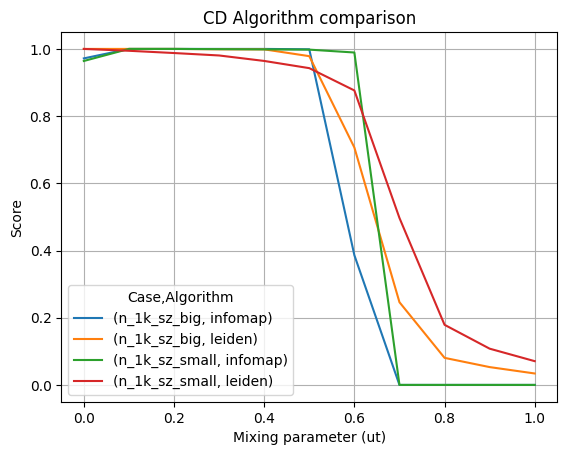

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
plot_and_compare(df)

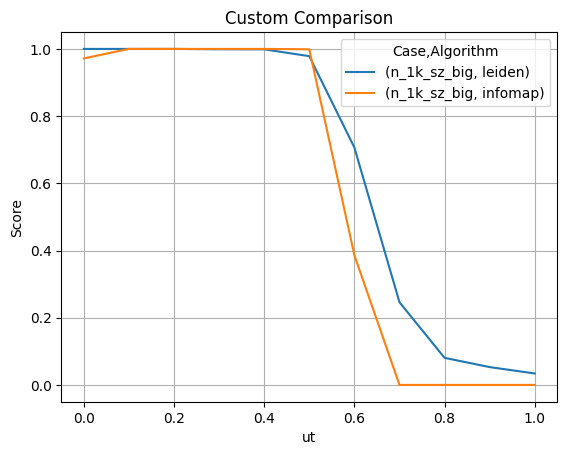

In [ ]:
plot_and_compare(df, 'leiden infomap', 'n_1k_sz_big')

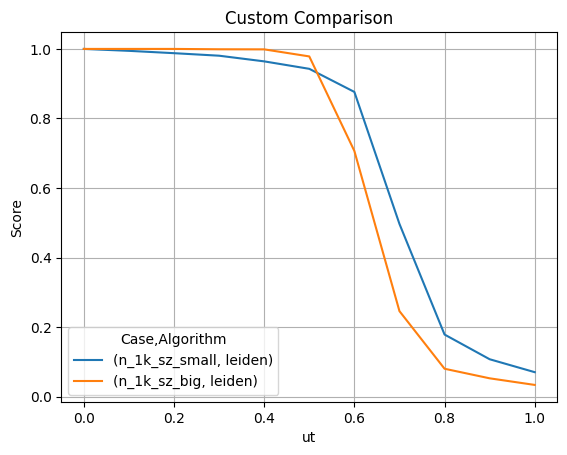

In [ ]:
plot_and_compare(df, 'leiden', 'n_1k_sz_small n_1k_sz_big')

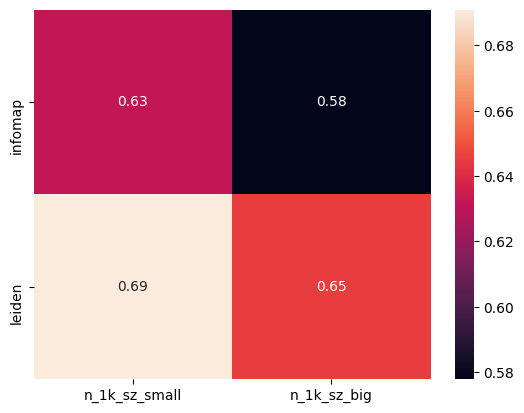

In [64]:
plot_and_compare(df, heat_map=True)

##Plotting Function (Bokeh)

In [34]:
from bokeh.io import output_notebook, show   # import output_file instead if not in a jupyter NB. 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral11
from bokeh.models import  HoverTool
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource,
                          LinearColorMapper, PrintfTickFormatter,)
from bokeh.transform import transform
output_notebook()

In [36]:
def plot_and_compare_bokeh(dataframe, algos_to_compare='all', cases_to_compare='all', heat_map=False):
  
  plt.style.use('default')
  algos_in_df = dataframe['Algorithm'].unique()
  cases_in_df = dataframe['Case'].unique()
  
  #Check input values (algos_to_compare)    
  if isinstance(algos_to_compare, str): 
    if algos_to_compare == 'all':
      algos_to_compare = algos_in_df
    else:
      algos_to_compare = list(algos_to_compare.split())
  elif (isinstance(algos_to_compare, list)) and (len(algos_to_compare)): 
    if any(not(c in algos_in_df) for c in algos_to_compare):
      raise ValueError('Invalid <algorithm> option. Verify available algorithm for current dataframe.')
    algos_to_compare = algos_to_compare    
  else:
    raise TypeError('Invalid <algorithm> input format. Please insert a list or a space-separated string of valide options or "all" to compare all of them.')

  #Check input values (cases_to_compare)    
  if isinstance(cases_to_compare, str): 
    if cases_to_compare == 'all':
      cases_to_compare = cases_in_df
    else:
      cases_to_compare = list(cases_to_compare.split())
  elif (isinstance(cases_to_compare, list)) and (len(cases_to_compare)): 
    if any(not(c in cases_in_df) for c in cases_to_compare):
      raise ValueError('Invalid <case> option. Verify available case for current dataframe.')
    cases_to_compare = cases_to_compare    
  else:
    raise TypeError('Invalid <case> input format. Please insert a list or a space-separated string of valide options or "all" to compare all of them.')

  #Plotting  
  if heat_map == False:
    # Create base figure
    tools_to_show = 'hover,box_zoom,pan,save,reset,wheel_zoom'
    p = figure(plot_width=500, plot_height=500, title="CD Algorithm comparison", tools=tools_to_show)

    # create color palette according the number of lines  
    mypalette = Spectral11[0:len(algos_to_compare)*len(cases_to_compare)]
    counter = 0

    for alg in algos_to_compare:
      for ca in cases_to_compare:
        data = dataframe[(dataframe['Algorithm'] == alg) & (dataframe['Case'] == ca)]
        data = data.groupby(['ut']).mean()
        data.reset_index(level=0, inplace=True)
        # add a line renderer
        plot = p.line('ut', 'Score', source=data, color=mypalette[counter], line_width=3, legend_label=(alg + ', ' + ca))
        counter += 1

    # show the tooltip
    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [('Score', '@Score')]
    hover.mode = 'mouse'
    p.legend.location = "bottom_left"
    p.legend.click_policy="hide"
    #output_file("CD_comparison.html", title="CD_comparison.py") /  Use if not in a Jupyter NB.
    show(p)   
  else:    
    df = pd.DataFrame(index=algos_to_compare, columns=cases_to_compare)
    for alg in algos_to_compare:
      for ca in cases_to_compare:
        data = dataframe[(dataframe['Algorithm'] == alg) & (dataframe['Case'] == ca)]
        df.loc[df.index == alg, ca] = data.groupby(['ut']).mean()['Score'].mean()
    df = df.astype(float)
    df.columns.name = 'cases'
    df.index.name = 'algorithms'

    # reshape to 1D array for avg_score with an algo and case for each row.
    new_df = pd.DataFrame(df.stack(), columns=['avg_score']).reset_index()
    source = ColumnDataSource(new_df)

    #Colormap to use
    mypalette = Spectral11[0:len(algos_to_compare)*len(cases_to_compare)]
    colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
    mapper = LinearColorMapper(palette=colors, low=new_df.avg_score.min(), high=new_df.avg_score.max())
    
    hm = figure(plot_width=500, plot_height=300, title="Comparison Heatmap",
           x_range=list(df.index), y_range=list(df.columns),
           toolbar_location=None, tools="", x_axis_location="below")
    
    hm.rect(x="algorithms", y="cases", width=1, height=1, source=source,
       line_color=None, fill_color=transform('avg_score', mapper))
    
    color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%0.2f"))
    
    hm.add_layout(color_bar, 'right')
    hm.axis.axis_line_color = None
    hm.axis.major_tick_line_color = None
    hm.axis.major_label_text_font_size = "12px"
    hm.axis.major_label_standoff = 0
    hm.xaxis.major_label_orientation = 0.0
    show(hm)    

In [38]:
plot_and_compare_bokeh(df)

In [39]:
plot_and_compare_bokeh(df, 'leiden infomap', 'n_1k_sz_big')

In [40]:
plot_and_compare_bokeh(df, 'leiden', 'n_1k_sz_big n_1k_sz_small')

In [42]:
plot_and_compare_bokeh(df, heat_map=True)

In [44]:
plot_and_compare_bokeh(df, 'leiden infomap', 'n_1k_sz_small', heat_map=True)

In [41]:
plot_and_compare_bokeh(df, 'leiden', 'n_1k_sz_big n_1k_sz_small', heat_map=True)